In [210]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from tqdm import tqdm

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")


%reload_ext autoreload
%autoreload 2

In [211]:
target = 'Nasdaque'

In [212]:
dataset = pd.read_pickle('data/processed_dataset.pkl')


n_feature = dataset.shape[1]
dataset['y'] = dataset[f'{target} Close']


x = dataset.iloc[:, :n_feature].values
y = dataset.iloc[:, n_feature].values

split = int(dataset.shape[0]* 0.8)

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

x = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.reshape(-1, 1))

train_x, test_x = x[:split], x[split:]
train_y, test_y = y[:split], y[split:]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

trainX: (1070, 97) trainY: (1070, 1)
testX: (268, 97) testY: (268, 1)


In [213]:
dataset = pd.read_pickle('data/processed_dataset.pkl')
# dataset[f'{target} Close'].plot()

In [214]:
from utils.VAE import VAE

train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([n_feature, 400, 400, 400, 10])
model = model.to(device)
learning_rate = 0.00003
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# model

In [215]:
num_epochs = 300
hist = np.zeros(num_epochs) 

loss_func = nn.BCELoss()

for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = loss_func(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    # print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))


100%|██████████| 300/300 [00:18<00:00, 16.49it/s]


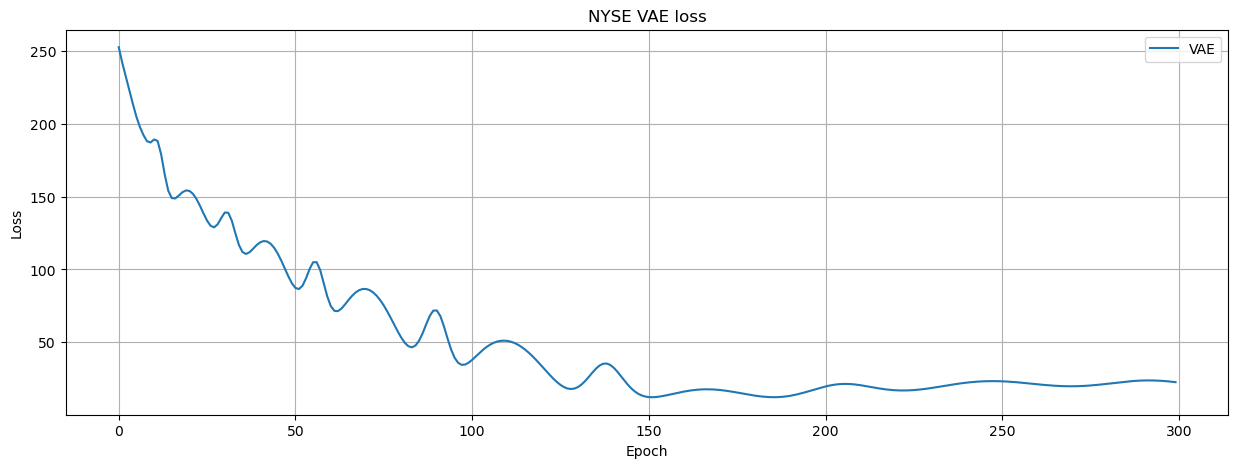

In [216]:
plt.figure(figsize=(15, 5))
plt.plot(hist, label='VAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.title(f'{target} VAE loss')
plt.savefig(f'images/{target} VAE loss.png', dpi=300, bbox_inches='tight')

In [217]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [218]:
def sliding_window(x, y, window, n_gen=1):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0] - n_gen):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + n_gen]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [219]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [220]:
num_days_for_predict = 10
num_days_to_predict = 5

In [221]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, num_days_for_predict, num_days_to_predict)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, num_days_for_predict, num_days_to_predict)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([1055, 10, 107]) train_y: torch.Size([1055, 1]) train_y_gan: torch.Size([1055, 15, 1])
test_x: torch.Size([253, 10, 107]) test_y: torch.Size([253, 1]) test_y_gan: torch.Size([253, 15, 1])


In [222]:
test_y.shape

(268, 1)

In [223]:
from utils.generator import Generator
from utils.discriminator import Discriminator
from utils.VAE import VAE

In [224]:
batch_size = 128
learning_rate = 0.00016
num_epochs = 165

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(
    input_size=model.config[0]+model.config[-1],
    output_size=num_days_to_predict
).to(device)
modelD = Discriminator(
    input_size=num_days_for_predict+num_days_to_predict,
).to(device)

criterion = nn.BCELoss()


In [225]:
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate)
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate)

In [226]:
num_epochs = 150

In [227]:
histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0

modelG.train()
for epoch in tqdm(range(num_epochs)):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :num_days_for_predict, :], fake_data.reshape(-1, num_days_to_predict, 1)], axis = 1)
        # print(fake_data.shape)

        dis_real_output = modelD(y)
        # print(dis_real_output.shape)
        # break
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)

        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    # print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

100%|██████████| 150/150 [00:41<00:00,  3.61it/s]


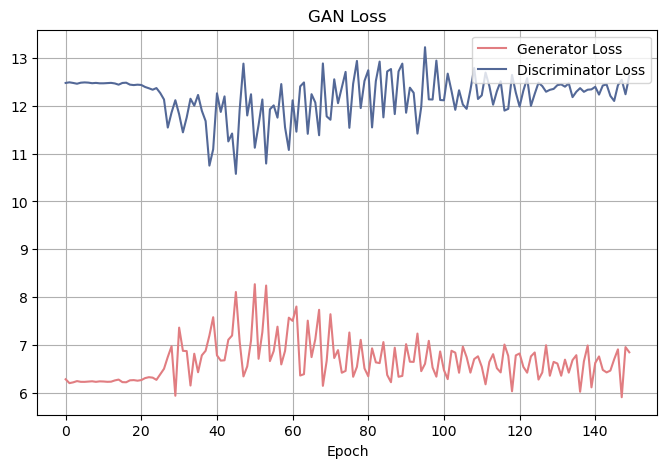

In [228]:
plt.figure(figsize=(8, 5))
plt.plot(histG, color='#E17D81', label='Generator Loss')
plt.plot(histD, color='#536897', label='Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(loc = 'upper right')
plt.savefig(f'images/{target} GAN Loss.png', dpi=300, bbox_inches='tight')

In [229]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy()).mean(axis=1)

y_test_true = y_scaler.inverse_transform(test_y_slide.reshape(-1, 1))
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy()).mean(axis=1)

Training dataset RMSE:354.8599462543546


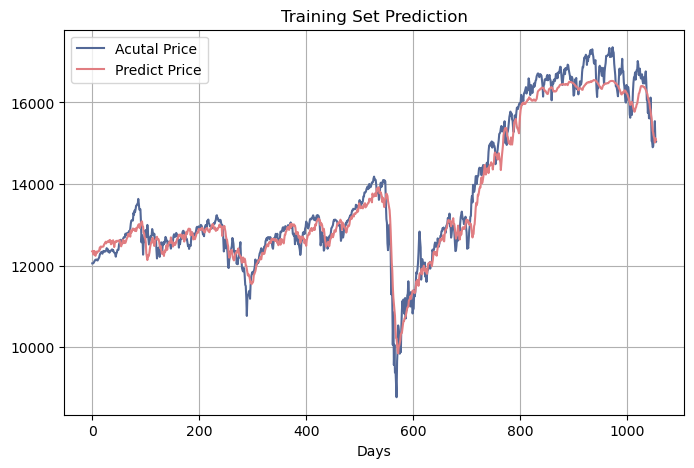

In [247]:
plt.figure(figsize=(8, 5))
plt.plot(y_train_true, color='#536897', label='Acutal Price')
plt.plot(y_train_pred, color='#E17D81', label='Predict Price')
plt.title('Training Set Prediction')
plt.xlabel('Days')
# original_xticks = plt.xticks()[0]
# original_xticks = original_xticks[original_xticks >= 0].astype(int)
# plt.xticks(original_xticks, [d.date() for d in dataset.index[original_xticks]])
plt.legend()
plt.grid()
plt.savefig(f'images/{target} train_set_prediction.png', dpi=300, bbox_inches='tight')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:599.3879826561215


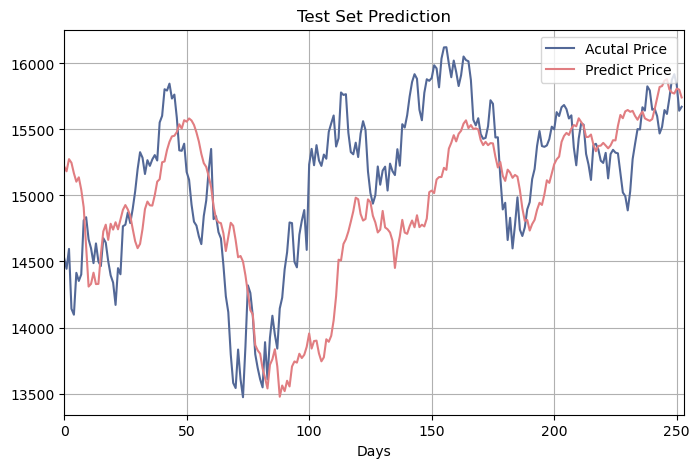

In [231]:
plt.figure(figsize=(8, 5))
plt.plot(y_test_true, color='#536897', label='Acutal Price')
plt.plot(y_test_pred, color='#E17D81', label='Predict Price')
plt.title('Test Set Prediction')
plt.xlabel('Days')
plt.legend(loc = 'upper right')
plt.grid()
plt.xlim([0, len(y_test_true)])
plt.savefig(f'images/{target} test_set_prediction.png', dpi=300, bbox_inches='tight')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')